# Project 3: Web APIs & NLP Part 3 Natural Language Processing

In [1]:
# imports
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
import re
import unicodedata
import nltk


## Importing and Exploring Data

In [2]:
# to make DataFrames easier to navigate through during cleaning/EDA
pd.set_option('display.max_columns',10000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)


In [3]:
# importing cleaned creative writing and tech support subreddit DataFrames
creative = pd.read_csv('data2/cleaned_creativewriting.csv')
techsupport = pd.read_csv('data2/cleaned_techsupport.csv')

In [4]:
# checking cleaned DataFrames' shapes
print(f"The cleaned technical support DataFrame has {techsupport.shape[0]} rows and {techsupport.shape[1]} columns")
print(f"The cleaned creative writing DataFrame has {creative.shape[0]} rows and {creative.shape[1]} columns")



The cleaned technical support DataFrame has 5120 rows and 3 columns
The cleaned creative writing DataFrame has 6928 rows and 3 columns


In [5]:
# creating new column for Classification with creative set to 0 and techsupport set to 1
creative['subreddit'] = 0
techsupport['subreddit'] = 1

In [6]:
# combining DataFrames
combo = pd.concat([creative,techsupport])

In [7]:
# checking datatypes 
combo.dtypes

selftext     object
author       object
title        object
subreddit     int64
dtype: object

In [8]:
# creating new column 'fulltext' combining selftext and title
combo['fulltext']=combo[['selftext','title']].agg(' '.join, axis =1)

In [9]:
combo.head()

,selftext,author,title,subreddit,fulltext
0,"if you happend to make a blog/ecommerce store about sex play and maybe sex toys how you would name it ? My first idea was Whipped - but domain is taken .. www.....com. \ni would like something that is not straightforward like 69store or sexer but something mysterious and fun but on point \nThank you,",raygreeen,Asking for a friend,0,"if you happend to make a blog/ecommerce store about sex play and maybe sex toys how you would name it ? My first idea was Whipped - but domain is taken .. www.....com. \ni would like something that is not straightforward like 69store or sexer but something mysterious and fun but on point \nThank you, Asking for a friend"
1,The floor is cold like it was that that night.\n\nI had tried to run into the street. \n\nYour look of betrayal burned into my sight. \n\nI am nothing but a bona-fide creep.\n\nAll of our memories now a blight.\n\nEvery sunrise is a burden without sleep.,a_deceased_person,That Night 🌙,0,The floor is cold like it was that that night.\n\nI had tried to run into the street. \n\nYour look of betrayal burned into my sight. \n\nI am nothing but a bona-fide creep.\n\nAll of our memories now a blight.\n\nEvery sunrise is a burden without sleep. That Night 🌙
2,In this factory of memories\n\nWe went our ways for a while\n\nLike a pencil writes a story\n\nMaking words or tracing lines\n\nDrawing worlds or coloring skies\n\nA whole new life for you and i\n\n.\nEven though sometimes the lead broke\n\nWe would just sharpen up our hope\n\nUntil that pencil was no more\n\nAnd today i can see the end\n\nSo I wanted to say my thanks\n\n.\nTo you before the rubber erases\n\nThe memories that we lived in.,Luxrayguy,Factory,0,In this factory of memories\n\nWe went our ways for a while\n\nLike a pencil writes a story\n\nMaking words or tracing lines\n\nDrawing worlds or coloring skies\n\nA whole new life for you and i\n\n.\nEven though sometimes the lead broke\n\nWe would just sharpen up our hope\n\nUntil that pencil was no more\n\nAnd today i can see the end\n\nSo I wanted to say my thanks\n\n.\nTo you before the rubber erases\n\nThe memories that we lived in. Factory
3,I'm panicking I think. Shoving my mouth into my fist. Silly fool slipping backwards for a regressive wish. A false narrative that loops reality in warmth seeking snakes....\n\nWriggling with stoic discomfort just for a taste. But I'm tripping into trouble with you. I hope these feelings aren't just waste.,a_deceased_person,delusions?,0,I'm panicking I think. Shoving my mouth into my fist. Silly fool slipping backwards for a regressive wish. A false narrative that loops reality in warmth seeking snakes....\n\nWriggling with stoic discomfort just for a taste. But I'm tripping into trouble with you. I hope these feelings aren't just waste. delusions?
4,"“america no longer creates prophets, only profits &amp; we’re all a lot more poor because of it. “ \n\n\n - my brains thoughts in the early hours of the morning",bmodelic,Desolate America,0,"“america no longer creates prophets, only profits &amp; we’re all a lot more poor because of it. “ \n\n\n - my brains thoughts in the early hours of the morning Desolate America"


## Natural Language Processing Parsing

In [10]:
# making list of columns for primary NLP parsing
col_combo = ['fulltext']

### Tokenize text data

In [11]:
# making function to remove whitespace, keep alphabet characters, and lowercase 
def tokendata(df,col_list):
    token = RegexpTokenizer(r'[\w\'\']+')
    for j in col_list:
        token_items = [token.tokenize(i.lower()) for i in df[j]]
        df[f'tokenized_{j}'] = token_items
    return df

In [12]:
# tokenize combined dataframes
combo = tokendata(combo, col_combo)
combo.head()

,selftext,author,title,subreddit,fulltext,tokenized_fulltext
0,"if you happend to make a blog/ecommerce store about sex play and maybe sex toys how you would name it ? My first idea was Whipped - but domain is taken .. www.....com. \ni would like something that is not straightforward like 69store or sexer but something mysterious and fun but on point \nThank you,",raygreeen,Asking for a friend,0,"if you happend to make a blog/ecommerce store about sex play and maybe sex toys how you would name it ? My first idea was Whipped - but domain is taken .. www.....com. \ni would like something that is not straightforward like 69store or sexer but something mysterious and fun but on point \nThank you, Asking for a friend","[if, you, happend, to, make, a, blog, ecommerce, store, about, sex, play, and, maybe, sex, toys, how, you, would, name, it, my, first, idea, was, whipped, but, domain, is, taken, www, com, i, would, like, something, that, is, not, straightforward, like, 69store, or, sexer, but, something, mysterious, and, fun, but, on, point, thank, you, asking, for, a, friend]"
1,The floor is cold like it was that that night.\n\nI had tried to run into the street. \n\nYour look of betrayal burned into my sight. \n\nI am nothing but a bona-fide creep.\n\nAll of our memories now a blight.\n\nEvery sunrise is a burden without sleep.,a_deceased_person,That Night 🌙,0,The floor is cold like it was that that night.\n\nI had tried to run into the street. \n\nYour look of betrayal burned into my sight. \n\nI am nothing but a bona-fide creep.\n\nAll of our memories now a blight.\n\nEvery sunrise is a burden without sleep. That Night 🌙,"[the, floor, is, cold, like, it, was, that, that, night, i, had, tried, to, run, into, the, street, your, look, of, betrayal, burned, into, my, sight, i, am, nothing, but, a, bona, fide, creep, all, of, our, memories, now, a, blight, every, sunrise, is, a, burden, without, sleep, that, night]"
2,In this factory of memories\n\nWe went our ways for a while\n\nLike a pencil writes a story\n\nMaking words or tracing lines\n\nDrawing worlds or coloring skies\n\nA whole new life for you and i\n\n.\nEven though sometimes the lead broke\n\nWe would just sharpen up our hope\n\nUntil that pencil was no more\n\nAnd today i can see the end\n\nSo I wanted to say my thanks\n\n.\nTo you before the rubber erases\n\nThe memories that we lived in.,Luxrayguy,Factory,0,In this factory of memories\n\nWe went our ways for a while\n\nLike a pencil writes a story\n\nMaking words or tracing lines\n\nDrawing worlds or coloring skies\n\nA whole new life for you and i\n\n.\nEven though sometimes the lead broke\n\nWe would just sharpen up our hope\n\nUntil that pencil was no more\n\nAnd today i can see the end\n\nSo I wanted to say my thanks\n\n.\nTo you before the rubber erases\n\nThe memories that we lived in. Factory,"[in, this, factory, of, memories, we, went, our, ways, for, a, while, like, a, pencil, writes, a, story, making, words, or, tracing, lines, drawing, worlds, or, coloring, skies, a, whole, new, life, for, you, and, i, even, though, sometimes, the, lead, broke, we, would, just, sharpen, up, our, hope, until, that, pencil, was, no, more, and, today, i, can, see, the, end, so, i, wanted, to, say, my, thanks, to, you, before, the, rubber, erases, the, memories, that, we, lived, in, factory]"
3,I'm panicking I think. Shoving my mouth into my fist. Silly fool slipping backwards for a regressive wish. A false narrative that loops reality in warmth seeking snakes....\n\nWriggling with stoic discomfort just for a taste. But I'm tripping into trouble with you. I hope these feelings aren't just waste.,a_deceased_person,delusions?,0,I'm panicking I think. Shoving my mouth into my fist. Silly fool slipping backwards for a regressive wish. A false narrative that loops reality in warmth seeking snakes....\n\nWriggling with stoic discomfort just for a taste. But I'm tripping into trouble with you. I hope these feelings aren't just waste. d

### Lemmatize text data

In [13]:
cols_list=['tokenized_fulltext']

In [14]:
def lemmad(words):
    lemma=WordNetLemmatizer()
    lemmad_row = [lemma.lemmatize(word) for word in words]
    return lemmad_row

In [15]:
# making function to lemmatize the text data

combo['lemmatized_tokenized_fulltext']=combo['tokenized_fulltext'].apply(lemmad)



In [16]:
combo.head()

,selftext,author,title,subreddit,fulltext,tokenized_fulltext,lemmatized_tokenized_fulltext
0,"if you happend to make a blog/ecommerce store about sex play and maybe sex toys how you would name it ? My first idea was Whipped - but domain is taken .. www.....com. \ni would like something that is not straightforward like 69store or sexer but something mysterious and fun but on point \nThank you,",raygreeen,Asking for a friend,0,"if you happend to make a blog/ecommerce store about sex play and maybe sex toys how you would name it ? My first idea was Whipped - but domain is taken .. www.....com. \ni would like something that is not straightforward like 69store or sexer but something mysterious and fun but on point \nThank you, Asking for a friend","[if, you, happend, to, make, a, blog, ecommerce, store, about, sex, play, and, maybe, sex, toys, how, you, would, name, it, my, first, idea, was, whipped, but, domain, is, taken, www, com, i, would, like, something, that, is, not, straightforward, like, 69store, or, sexer, but, something, mysterious, and, fun, but, on, point, thank, you, asking, for, a, friend]","[if, you, happend, to, make, a, blog, ecommerce, store, about, sex, play, and, maybe, sex, toy, how, you, would, name, it, my, first, idea, wa, whipped, but, domain, is, taken, www, com, i, would, like, something, that, is, not, straightforward, like, 69store, or, sexer, but, something, mysterious, and, fun, but, on, point, thank, you, asking, for, a, friend]"
1,The floor is cold like it was that that night.\n\nI had tried to run into the street. \n\nYour look of betrayal burned into my sight. \n\nI am nothing but a bona-fide creep.\n\nAll of our memories now a blight.\n\nEvery sunrise is a burden without sleep.,a_deceased_person,That Night 🌙,0,The floor is cold like it was that that night.\n\nI had tried to run into the street. \n\nYour look of betrayal burned into my sight. \n\nI am nothing but a bona-fide creep.\n\nAll of our memories now a blight.\n\nEvery sunrise is a burden without sleep. That Night 🌙,"[the, floor, is, cold, like, it, was, that, that, night, i, had, tried, to, run, into, the, street, your, look, of, betrayal, burned, into, my, sight, i, am, nothing, but, a, bona, fide, creep, all, of, our, memories, now, a, blight, every, sunrise, is, a, burden, without, sleep, that, night]","[the, floor, is, cold, like, it, wa, that, that, night, i, had, tried, to, run, into, the, street, your, look, of, betrayal, burned, into, my, sight, i, am, nothing, but, a, bona, fide, creep, all, of, our, memory, now, a, blight, every, sunrise, is, a, burden, without, sleep, that, night]"
2,In this factory of memories\n\nWe went our ways for a while\n\nLike a pencil writes a story\n\nMaking words or tracing lines\n\nDrawing worlds or coloring skies\n\nA whole new life for you and i\n\n.\nEven though sometimes the lead broke\n\nWe would just sharpen up our hope\n\nUntil that pencil was no more\n\nAnd today i can see the end\n\nSo I wanted to say my thanks\n\n.\nTo you before the rubber erases\n\nThe memories that we lived in.,Luxrayguy,Factory,0,In this factory of memories\n\nWe went our ways for a while\n\nLike a pencil writes a story\n\nMaking words or tracing lines\n\nDrawing worlds or coloring skies\n\nA whole new life for you and i\n\n.\nEven though sometimes the lead broke\n\nWe would just sharpen up our hope\n\nUntil that pencil was no more\n\nAnd today i can see the end\n\nSo I wanted to say my thanks\n\n.\nTo you before the rubber erases\n\nThe memories that we lived in. Factory,"[in, this, factory, of, memories, we, went, our, ways, for, a, while, like, a, pencil, writes, a, story, making, words, or, tracing, lines, drawing, worlds, or, coloring, skies, a, whole, new, life, for, you, and, i, even, though, sometimes, the, lead, broke, we, would, just, sharpen, up, our, hope, until, that, pencil, was, no, more, and, today, i, can, see, the, end, so, i, wanted, to, say, my, thanks, to, you, before, the, rubber, erases, the, me

### Stemmatize text data

In [17]:
# making list of tockenized columns to stemmatize later
cols_list=['lemmatize_tokenized_fulltext']

In [18]:

def stemmad(words):
    stemma=PorterStemmer()
    stemmad_row = [stemma.stem(word) for word in words]
    return stemmad_row

In [19]:
# making function to stemmatize the text data
combo['stemmatized_lemmatized_tokenized_fulltext']=combo['lemmatized_tokenized_fulltext'].apply(stemmad)



In [20]:
combo.head()

,selftext,author,title,subreddit,fulltext,tokenized_fulltext,lemmatized_tokenized_fulltext,stemmatized_lemmatized_tokenized_fulltext
0,"if you happend to make a blog/ecommerce store about sex play and maybe sex toys how you would name it ? My first idea was Whipped - but domain is taken .. www.....com. \ni would like something that is not straightforward like 69store or sexer but something mysterious and fun but on point \nThank you,",raygreeen,Asking for a friend,0,"if you happend to make a blog/ecommerce store about sex play and maybe sex toys how you would name it ? My first idea was Whipped - but domain is taken .. www.....com. \ni would like something that is not straightforward like 69store or sexer but something mysterious and fun but on point \nThank you, Asking for a friend","[if, you, happend, to, make, a, blog, ecommerce, store, about, sex, play, and, maybe, sex, toys, how, you, would, name, it, my, first, idea, was, whipped, but, domain, is, taken, www, com, i, would, like, something, that, is, not, straightforward, like, 69store, or, sexer, but, something, mysterious, and, fun, but, on, point, thank, you, asking, for, a, friend]","[if, you, happend, to, make, a, blog, ecommerce, store, about, sex, play, and, maybe, sex, toy, how, you, would, name, it, my, first, idea, wa, whipped, but, domain, is, taken, www, com, i, would, like, something, that, is, not, straightforward, like, 69store, or, sexer, but, something, mysterious, and, fun, but, on, point, thank, you, asking, for, a, friend]","[if, you, happend, to, make, a, blog, ecommerc, store, about, sex, play, and, mayb, sex, toy, how, you, would, name, it, my, first, idea, wa, whip, but, domain, is, taken, www, com, i, would, like, someth, that, is, not, straightforward, like, 69store, or, sexer, but, someth, mysteri, and, fun, but, on, point, thank, you, ask, for, a, friend]"
1,The floor is cold like it was that that night.\n\nI had tried to run into the street. \n\nYour look of betrayal burned into my sight. \n\nI am nothing but a bona-fide creep.\n\nAll of our memories now a blight.\n\nEvery sunrise is a burden without sleep.,a_deceased_person,That Night 🌙,0,The floor is cold like it was that that night.\n\nI had tried to run into the street. \n\nYour look of betrayal burned into my sight. \n\nI am nothing but a bona-fide creep.\n\nAll of our memories now a blight.\n\nEvery sunrise is a burden without sleep. That Night 🌙,"[the, floor, is, cold, like, it, was, that, that, night, i, had, tried, to, run, into, the, street, your, look, of, betrayal, burned, into, my, sight, i, am, nothing, but, a, bona, fide, creep, all, of, our, memories, now, a, blight, every, sunrise, is, a, burden, without, sleep, that, night]","[the, floor, is, cold, like, it, wa, that, that, night, i, had, tried, to, run, into, the, street, your, look, of, betrayal, burned, into, my, sight, i, am, nothing, but, a, bona, fide, creep, all, of, our, memory, now, a, blight, every, sunrise, is, a, burden, without, sleep, that, night]","[the, floor, is, cold, like, it, wa, that, that, night, i, had, tri, to, run, into, the, street, your, look, of, betray, burn, into, my, sight, i, am, noth, but, a, bona, fide, creep, all, of, our, memori, now, a, blight, everi, sunris, is, a, burden, without, sleep, that, night]"
2,In this factory of memories\n\nWe went our ways for a while\n\nLike a pencil writes a story\n\nMaking words or tracing lines\n\nDrawing worlds or coloring skies\n\nA whole new life for you and i\n\n.\nEven though sometimes the lead broke\n\nWe would just sharpen up our hope\n\nUntil that pencil was no more\n\nAnd today i can see the end\n\nSo I wanted to say my thanks\n\n.\nTo you before the rubber erases\n\nThe memories that we lived in.,Luxrayguy,Factory,0,In this factory of memories\n\nWe went our ways for a while\n\nLike a pencil writes a story\n\nMaking words or tracing lines\n\nDrawing worlds or coloring skies\n\nA whole new life for you and i\n\n.\nEven though sometimes the lead b

# EDA

In [21]:
combo1=combo.copy()

In [22]:
combo1['length']=[len(x) for x in combo1['stemmatized_lemmatized_tokenized_fulltext']]

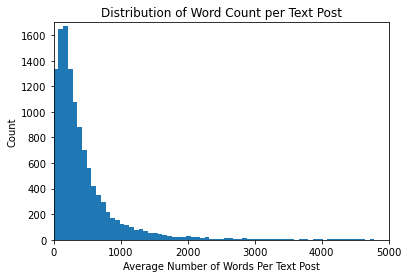

In [27]:
plt.hist(combo1['length'], bins=200)
plt.xlabel('Average Number of Words Per Text Post')
plt.ylabel('Count')
plt.title('Distribution of Word Count per Text Post')
plt.xlim(0,5000)
plt.ylim(0, 1700);
plt.savefig('wordcountdistribution')

n. This figure represents the distribution of word count per text post

In [24]:
combo['stemmatized_lemmatized_tokenized_fulltext'] = [' '.join(l) for l in combo['stemmatized_lemmatized_tokenized_fulltext']]

In [25]:
combo.head()

,selftext,author,title,subreddit,fulltext,tokenized_fulltext,lemmatized_tokenized_fulltext,stemmatized_lemmatized_tokenized_fulltext
0,"if you happend to make a blog/ecommerce store about sex play and maybe sex toys how you would name it ? My first idea was Whipped - but domain is taken .. www.....com. \ni would like something that is not straightforward like 69store or sexer but something mysterious and fun but on point \nThank you,",raygreeen,Asking for a friend,0,"if you happend to make a blog/ecommerce store about sex play and maybe sex toys how you would name it ? My first idea was Whipped - but domain is taken .. www.....com. \ni would like something that is not straightforward like 69store or sexer but something mysterious and fun but on point \nThank you, Asking for a friend","[if, you, happend, to, make, a, blog, ecommerce, store, about, sex, play, and, maybe, sex, toys, how, you, would, name, it, my, first, idea, was, whipped, but, domain, is, taken, www, com, i, would, like, something, that, is, not, straightforward, like, 69store, or, sexer, but, something, mysterious, and, fun, but, on, point, thank, you, asking, for, a, friend]","[if, you, happend, to, make, a, blog, ecommerce, store, about, sex, play, and, maybe, sex, toy, how, you, would, name, it, my, first, idea, wa, whipped, but, domain, is, taken, www, com, i, would, like, something, that, is, not, straightforward, like, 69store, or, sexer, but, something, mysterious, and, fun, but, on, point, thank, you, asking, for, a, friend]",if you happend to make a blog ecommerc store about sex play and mayb sex toy how you would name it my first idea wa whip but domain is taken www com i would like someth that is not straightforward like 69store or sexer but someth mysteri and fun but on point thank you ask for a friend
1,The floor is cold like it was that that night.\n\nI had tried to run into the street. \n\nYour look of betrayal burned into my sight. \n\nI am nothing but a bona-fide creep.\n\nAll of our memories now a blight.\n\nEvery sunrise is a burden without sleep.,a_deceased_person,That Night 🌙,0,The floor is cold like it was that that night.\n\nI had tried to run into the street. \n\nYour look of betrayal burned into my sight. \n\nI am nothing but a bona-fide creep.\n\nAll of our memories now a blight.\n\nEvery sunrise is a burden without sleep. That Night 🌙,"[the, floor, is, cold, like, it, was, that, that, night, i, had, tried, to, run, into, the, street, your, look, of, betrayal, burned, into, my, sight, i, am, nothing, but, a, bona, fide, creep, all, of, our, memories, now, a, blight, every, sunrise, is, a, burden, without, sleep, that, night]","[the, floor, is, cold, like, it, wa, that, that, night, i, had, tried, to, run, into, the, street, your, look, of, betrayal, burned, into, my, sight, i, am, nothing, but, a, bona, fide, creep, all, of, our, memory, now, a, blight, every, sunrise, is, a, burden, without, sleep, that, night]",the floor is cold like it wa that that night i had tri to run into the street your look of betray burn into my sight i am noth but a bona fide creep all of our memori now a blight everi sunris is a burden without sleep that night
2,In this factory of memories\n\nWe went our ways for a while\n\nLike a pencil writes a story\n\nMaking words or tracing lines\n\nDrawing worlds or coloring skies\n\nA whole new life for you and i\n\n.\nEven though sometimes the lead broke\n\nWe would just sharpen up our hope\n\nUntil that pencil was no more\n\nAnd today i can see the end\n\nSo I wanted to say my thanks\n\n.\nTo you before the rubber erases\n\nThe memories that we lived in.,Luxrayguy,Factory,0,In this factory of memories\n\nWe went our ways for a while\n\nLike a pencil writes a story\n\nMaking words or tracing lines\n\nDrawing worlds or coloring skies\n\nA whole new life for you and i\n\n.\nEven though sometimes the lead broke\n\nWe would just sharpen up our hope\n\nUntil that pencil was no more\n\nAnd today i can see the end\n\nSo I 

## Exporting to CSV

In [26]:
combo.to_csv('data2/combo.csv',index=False)